# DB 종료 후 DF 작업하기

- m_df.csv는 날짜, 미세먼지농도, 강수량, 적설량(cm), 평일/주말, 계절, 연도, 미세먼지등급, 강수량등급, 적설량등급, 적설량(mm)

- m_df2.csv는 m_df와 동일한 컬럼 갯수와 이름을 가지지만, 미세먼지농도, 강수량, 적설량(mm) 3개 컬럼이 min-max스케일 됨

여기서부터 시작

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
# from sqlalchemy import create_engine
# !pip install scikit-learn
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
import os

In [2]:
# matplotlib 한글 사용

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 데이터 불러와서 가공하기

In [3]:
fd_df = pd.read_csv('./data/fine_dust.csv')
wt_df = pd.read_csv('./data/weather_data.csv')
fd_df.columns, wt_df.columns

(Index(['Unnamed: 0', 'station_id', 'station_name', 'date', 'fine_dust(㎍/㎥)'], dtype='object'),
 Index(['Unnamed: 0', 'station_id', 'station_name', 'date_time', 'avg_temp',
        'min_temp', 'max_temp', 'daily_precipitation', 'avg_wind_speed',
        'daily_snow_depth'],
       dtype='object'))

In [ ]:
# 필요 컬럼만 자르기
fd_df = fd_df.loc[:, ['date', 'fine_dust(㎍/㎥)']] 
fd_df.columns=['Date', 'Fine_dust(㎍/㎥)']
wt_df = wt_df.loc[:, ['date_time', 'daily_precipitation', 'daily_snow_depth']]
wt_df.columns=['Date', 'precipitation(mm)', 'snow_depth(cm)']
fd_df.info(), wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323 entries, 0 to 1322
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1323 non-null   object
 1   Fine_dust(㎍/㎥)  1323 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1399 non-null   object 
 1   Precipitation(mm)  591 non-null    float64
 2   Snow_depth(cm)     92 non-null     float64
dtypes: float64(2), object(1)
memory usage: 32.9+ KB


(None, None)

In [5]:
# 미세먼지에서 아래 날짜 누락됨 (날짜 자체가 없음)
# Timestamp('2021-01-23 00:00:00'),
#  Timestamp('2021-03-01 00:00:00'),
#  Timestamp('2021-03-28 00:00:00'),
#  Timestamp('2021-04-04 00:00:00'),
#  Timestamp('2021-05-28 00:00:00'),
#  Timestamp('2021-05-30 00:00:00'),
#  Timestamp('2021-10-02 00:00:00'),
#  Timestamp('2021-11-21 00:00:00'),
#  Timestamp('2021-11-22 00:00:00'),
#  Timestamp('2022-02-15 00:00:00'),
#  Timestamp('2022-03-07 00:00:00'),
#  Timestamp('2022-03-14 00:00:00'),
#  Timestamp('2022-03-18 00:00:00'),
#  Timestamp('2022-03-19 00:00:00'),
#  Timestamp('2022-03-26 00:00:00'),
#  Timestamp('2022-04-01 00:00:00'),
#  Timestamp('2022-04-15 00:00:00'),
#  Timestamp('2022-04-29 00:00:00'),
#  Timestamp('2022-06-06 00:00:00'),
#  Timestamp('2022-06-07 00:00:00'),
#  Timestamp('2022-06-24 00:00:00'),
#  Timestamp('2022-06-30 00:00:00'),
#  Timestamp('2022-08-02 00:00:00'),
#  Timestamp('2022-08-08 00:00:00'),
#  Timestamp('2022-08-09 00:00:00'),
#  Timestamp('2022-09-05 00:00:00'),
#  Timestamp('2022-09-06 00:00:00'),
#  Timestamp('2022-10-06 00:00:00'),
#  Timestamp('2022-10-08 00:00:00'),
#  Timestamp('2022-10-10 00:00:00'),
#  Timestamp('2022-10-25 00:00:00'),
#  Timestamp('2022-10-26 00:00:00'),
#  Timestamp('2023-01-14 00:00:00'),
#  Timestamp('2023-01-15 00:00:00'),
#  Timestamp('2023-04-05 00:00:00'),
#  Timestamp('2023-05-05 00:00:00'),
#  Timestamp('2023-05-06 00:00:00'),
#  Timestamp('2023-06-09 00:00:00'),
#  Timestamp('2023-07-09 00:00:00'),
#  Timestamp('2023-08-08 00:00:00'),
#  Timestamp('2023-08-09 00:00:00'),
#  Timestamp('2023-08-10 00:00:00'),
#  Timestamp('2023-09-08 00:00:00'),
#  Timestamp('2023-09-21 00:00:00'),
#  Timestamp('2023-09-26 00:00:00'),
#  Timestamp('2023-11-10 00:00:00'),
#  Timestamp('2023-12-11 00:00:00'),
#  Timestamp('2023-12-12 00:00:00'),
#  Timestamp('2023-12-14 00:00:00'),
#  Timestamp('2023-12-15 00:00:00'),
#  Timestamp('2024-01-20 00:00:00'),
#  Timestamp('2024-02-05 00:00:00'),
#  Timestamp('2024-02-21 00:00:00'),
#  Timestamp('2024-02-22 00:00:00'),
#  Timestamp('2024-03-25 00:00:00'),
#  Timestamp('2024-03-26 00:00:00'),
#  Timestamp('2024-03-27 00:00:00'),
#  Timestamp('2024-05-06 00:00:00'),
#  Timestamp('2024-05-15 00:00:00'),
#  Timestamp('2024-05-16 00:00:00'),
#  Timestamp('2024-05-17 00:00:00'),
#  Timestamp('2024-06-03 00:00:00'),
#  Timestamp('2024-07-22 00:00:00'),
#  Timestamp('2024-07-23 00:00:00'),
#  Timestamp('2024-07-24 00:00:00'),
#  Timestamp('2024-09-12 00:00:00'),
#  Timestamp('2024-09-16 00:00:00'),
#  Timestamp('2024-09-21 00:00:00'),
#  Timestamp('2024-09-22 00:00:00'),
#  Timestamp('2024-09-23 00:00:00'),
#  Timestamp('2024-09-24 00:00:00'),
#  Timestamp('2024-09-27 00:00:00'),
#  Timestamp('2024-10-19 00:00:00'),
#  Timestamp('2024-10-20 00:00:00'),
#  Timestamp('2024-10-23 00:00:00'),
#  Timestamp('2024-10-29 00:00:00')

In [6]:
# 미세먼지, 비, 눈 데이터프레임 합치기
df = pd.merge(left=fd_df, right=wt_df, how='outer', on="Date")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1399 non-null   object 
 1   Fine_dust(㎍/㎥)     1323 non-null   float64
 2   Precipitation(mm)  591 non-null    float64
 3   Snow_depth(cm)     92 non-null     float64
dtypes: float64(3), object(1)
memory usage: 43.8+ KB


### 날짜를 기준으로 년, 계절, 평일/주말(+공휴일) 나누기

df의 Date의 타입 변경

In [7]:
df.info() # date 타입이 object임을 확인
df['Date'] = pd.to_datetime(df['Date'])
df.info() # date타입이 datetime64[ns]으로 변경됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               1399 non-null   object 
 1   Fine_dust(㎍/㎥)     1323 non-null   float64
 2   Precipitation(mm)  591 non-null    float64
 3   Snow_depth(cm)     92 non-null     float64
dtypes: float64(3), object(1)
memory usage: 43.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1323 non-null   float64       
 2   Precipitation(mm)  591 non-null    float64       
 3   Snow_depth(cm)     92 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 43.8 KB


In [8]:
# fine_dust["Date"]에 따라 평일, 주말 나누기(월~금 : 0~4, 토일 : 5, 6)
df["Day"] = np.where(df["Date"].dt.weekday < 5, "Weekday", "Weekend")
df


,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day
0,2021-01-01,36.0,NaN,NaN,Weekday
1,2021-01-02,43.0,NaN,NaN,Weekend
2,2021-01-03,47.0,NaN,NaN,Weekend
3,2021-01-04,50.0,0.0,0.0,Weekday
4,2021-01-05,37.0,0.0,0.0,Weekday
...,...,...,...,...,...
1394,2024-10-26,26.0,NaN,NaN,Weekend
1395,2024-10-27,27.0,0.0,NaN,Weekend
1396,2024-10-28,38.0,0.0,NaN,Weekday
1397,2024-10-29,NaN,0.0,NaN,Weekday


공휴일 데이터인 hd의 date의 타입 변경

In [9]:
hd = pd.read_csv('./data/hd_21_24.csv', encoding="CP949")
hd.rename(columns={"일시":"date"}, inplace=True)
hd['date'] = pd.to_datetime(hd['date'])
hd.columns=['Date', 'dateName']
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      66 non-null     datetime64[ns]
 1   dateName  66 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.2+ KB


fine_dust['day_type'] 만들어서 평일/주말+공휴일로 나누기 (공휴일은 주말로 처리)

In [10]:
# df와 hd DF 합치기
m_df = pd.merge(df, hd, how='outer', on='Date')
m_df.head(), m_df.tail()

(        Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm)      Day  \
 0 2021-01-01            36.0                NaN             NaN  Weekday   
 1 2021-01-02            43.0                NaN             NaN  Weekend   
 2 2021-01-03            47.0                NaN             NaN  Weekend   
 3 2021-01-04            50.0                0.0             0.0  Weekday   
 4 2021-01-05            37.0                0.0             0.0  Weekday   
 
   dateName  
 0     1월1일  
 1      NaN  
 2      NaN  
 3      NaN  
 4      NaN  ,
            Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm)      Day  \
 1395 2024-10-27            27.0                0.0             NaN  Weekend   
 1396 2024-10-28            38.0                0.0             NaN  Weekday   
 1397 2024-10-29             NaN                0.0             NaN  Weekday   
 1398 2024-10-30            28.0                NaN             NaN  Weekday   
 1399 2024-12-25             NaN                NaN

In [11]:
# date_name2 시리즈를 만들어서 
# dateName이 있다면, 주말처리
# 없다면, Day의 평일/주말 값을 가져오기
# apply 활용
date_name2 = m_df.apply(lambda row : 'Weekend' 
                        if str(row['dateName']) != 'nan' else row['Day'], axis=1)

In [ ]:
# apply 활용해서 평일, 주말(+공휴일)로 나눈 값을
# 합친 df에 적용하기 
m_df['day_type'] = date_name2

# 필요한 컬럼/행으로 자르기
m_df = m_df.loc[:, ['Date', 'Fine_dust(㎍/㎥)',  'precipitation(mm)', 'snow_depth(cm)', 'day_type']]
m_df = m_df.iloc[:1399, :]
m_df.head(1), m_df.tail(1)

(        Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type
 0 2021-01-01            36.0                NaN             NaN  Weekend,
            Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type
 1398 2024-10-30            28.0                NaN             NaN  Weekday)

병합된 DF을 계절별, 연도별로 구분하기

In [ ]:
# Date를 기준으로 계절별 구분 
# (봄: 3~5, 여름: 6~8, 가을: 9~11, 겨울: 12~2)
conditions = [
    ( m_df["Date"].dt.month >= 3 ) & ( m_df["Date"].dt.month <= 5 ),
    ( m_df["Date"].dt.month >= 6 ) & ( m_df["Date"].dt.month <= 8 ),
    ( m_df["Date"].dt.month >= 9 ) & ( m_df["Date"].dt.month <= 11 ),
]
season = ["Spring", "Summer", "Fall"]
m_df["season"] = np.select(conditions, season, default="Winter")

print( m_df.iloc[58:60, :] )
print( m_df.iloc[150:152, :] )
print( m_df.iloc[242:244, :] )
print( m_df.iloc[333:335, :] )

         Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
58 2021-02-28            32.0                NaN             NaN  Weekend   
59 2021-03-01             NaN               67.5             2.3  Weekend   

    Season  
58  Winter  
59  Spring  
          Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
150 2021-05-31            59.0                4.0             NaN  Weekday   
151 2021-06-01            52.0                3.2             NaN  Weekday   

     Season  
150  Spring  
151  Summer  
          Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
242 2021-08-31            37.0               77.4             NaN  Weekday   
243 2021-09-01             9.0                0.8             NaN  Weekday   

     Season  
242  Summer  
243    Fall  
          Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
333 2021-11-30            31.0               27.2             NaN  Weekday   
334 2021-12-01     

In [ ]:
# Date를 기준으로 연도별 구분 
m_df["year"] = m_df["Date"].dt.year
print( m_df.iloc[364:366, :] )

          Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
364 2021-12-31            21.0                NaN             NaN  Weekday   
365 2022-01-01            34.0                NaN             NaN  Weekend   

     Season  Year  
364  Winter  2021  
365  Winter  2022  


결측치 처리

In [ ]:
# 미세먼지 - 결측치는 계절별 평균으로 입력

# m_df[m_df['Fine_dust(㎍/㎥)'].isnull()] # 미세먼지에서 결측치 확인 

# 계절별 평균 구하기
season_means = m_df.groupby('season')['Fine_dust(㎍/㎥)'].mean()
season_means
                # Fall      29.830116
                # Spring    57.397101
                # Summer    28.134503
                # Winter    46.641509

# 결측치행에 평균값 넣기
m_df["Fine_dust(㎍/㎥)"] = m_df["Fine_dust(㎍/㎥)"]. \
                        fillna(m_df.groupby("season")["Fine_dust(㎍/㎥)"].transform("mean"))

m_df[m_df['Fine_dust(㎍/㎥)'].isnull()]

,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year


In [ ]:
# 강수량, 적설량 - 결측치는 0으로 입력
m_df.fillna({"precipitation(mm)": 0, "snow_depth(cm)": 0}, inplace=True)
m_df.isnull().sum()

Date                 0
Fine_dust(㎍/㎥)       0
Precipitation(mm)    0
Snow_depth(cm)       0
Day_type             0
Season               0
Year                 0
dtype: int64

미세먼지/강수량/적설량 등급 메기기

In [ ]:
# 미세먼지
# 좋음 (0-30 ㎍/m³) → Good
# 보통 (31-80 ㎍/m³) → Moderate
# 나쁨 (81-150 ㎍/m³) → Bad
# 매우 나쁨 (151 ㎍/m³ 이상) → Very Bad

# 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (m_df['Fine_dust(㎍/㎥)'] <= 30),
    (m_df['Fine_dust(㎍/㎥)'] > 30) & (m_df['Fine_dust(㎍/㎥)'] <= 80),
    (m_df['Fine_dust(㎍/㎥)'] > 80) & (m_df['Fine_dust(㎍/㎥)'] <= 150),
    (m_df['Fine_dust(㎍/㎥)'] > 150),
]

values = ['Good', 'Normal', 'Bad', 'Very_bad']

m_df["FD_grade"] = np.select(conditionlist, values, default="Unknown")
m_df.head(2)

,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year,FD_Grade
0,2021-01-01,36.0,0.0,0.0,Weekend,Winter,2021,Normal
1,2021-01-02,43.0,0.0,0.0,Weekend,Winter,2021,Normal


In [ ]:
# 강수량
# 건조 (Dry): 강수량이 없는 날, 즉 0mm
# 약강수 (Light): 0mm < 강수량 ≤ 10mm
# 중강수 (Moderate): 10mm < 강수량 ≤ 50mm
# 대강수 (Heavy): 강수량 > 50mm

# 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (m_df['precipitation(mm)'] == 00),
    (m_df['precipitation(mm)'] > 00) & (m_df['precipitation(mm)'] <= 10),
    (m_df['precipitation(mm)'] > 10) & (m_df['precipitation(mm)'] <= 50),
    (m_df['precipitation(mm)'] > 50),
]

values = ['Dry', 'Light', 'Moderate', 'Heavy']

m_df["p_grade"] = np.select(conditionlist, values, default="Dry")
m_df.head(2), m_df.tail(2)

(        Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
 0 2021-01-01            36.0                0.0             0.0  Weekend   
 1 2021-01-02            43.0                0.0             0.0  Weekend   
 
    Season  Year FD_Grade P_Grade  
 0  Winter  2021   Normal     Dry  
 1  Winter  2021   Normal     Dry  ,
            Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
 1397 2024-10-29       28.840909                0.0             0.0  Weekday   
 1398 2024-10-30       28.000000                0.0             0.0  Weekday   
 
      Season  Year FD_Grade P_Grade  
 1397   Fall  2024     Good     Dry  
 1398   Fall  2024     Good     Dry  )

In [ ]:
# 적설량
# 무적설 (No Snow): 적설량 = 0cm
# 소적설 (Light Snow): 0cm < 적설량 ≤ 2cm
# 중적설 (Moderate Snow): 2cm < 적설량 ≤ 10cm
# 대적설 (Heavy Snow): 적설량 > 10cm

# 새로운 컬럼을 생성하고 조건에 따라 값 입력
conditionlist = [
    (m_df['snow_depth(cm)'] == 00),
    (m_df['snow_depth(cm)'] > 00) & (m_df['snow_depth(cm)'] <= 2),
    (m_df['snow_depth(cm)'] > 2) & (m_df['snow_depth(cm)'] <= 10),
    (m_df['snow_depth(cm)'] > 10),
]

values = ['No_Snow', 'Light_Snow', 'Moderate_Snow', 'Heavy_Snow']

m_df["s_grade"] = np.select(conditionlist, values, default="Dry")
m_df.head(2)
m_df.tail(2)


,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year,FD_Grade,P_Grade,S_Grade
1397,2024-10-29,28.840909,0.0,0.0,Weekday,Fall,2024,Good,Dry,No_Snow
1398,2024-10-30,28.000000,0.0,0.0,Weekday,Fall,2024,Good,Dry,No_Snow


범주화

In [ ]:
# 범주화 - 계절/미세먼지등급/강수량등급/적설량등급
# 순서있는 범주형 : ordered = True, 순서 없는 범주형 : ordered = False
c_season = ["Spring", "Summer", "Fall", "Winter"]
c_season1 = CategoricalDtype(categories = c_season, ordered = True)

c_FD_grade = ['Good', 'Normal', 'Bad', 'Very_bad']
c_FD_grade1 = CategoricalDtype(categories = c_FD_grade, ordered = True)

c_p_grade = ['Dry', 'Light', 'Moderate', 'Heavy']
c_p_grade1 = CategoricalDtype(categories = c_p_grade, ordered = True)

c_s_grade = ['No_Snow', 'Light_Snow', 'Moderate_Snow', 'Heavy_Snow']
c_s_grade1 = CategoricalDtype(categories = c_s_grade, ordered = True)

m_df["season"] = m_df["season"].astype(c_season1)
m_df["FD_grade"] = m_df["FD_grade"].astype(c_FD_grade1)
m_df["p_grade"] = m_df["p_grade"].astype(c_p_grade1)
m_df["s_grade"] = m_df["s_grade"].astype(c_s_grade1)
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1399 non-null   float64       
 2   Precipitation(mm)  1399 non-null   float64       
 3   Snow_depth(cm)     1399 non-null   float64       
 4   Day_type           1399 non-null   object        
 5   Season             1399 non-null   category      
 6   Year               1399 non-null   int32         
 7   FD_Grade           1399 non-null   category      
 8   P_Grade            1399 non-null   category      
 9   S_Grade            1399 non-null   category      
dtypes: category(4), datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 66.5+ KB


### 데이터 분석

1. 단일 그룹 분석

- 강수량, 적설량 (단일 그룹 분석)

In [21]:
def group_analysis_by_single_column(df, group_col_name, col_name):
    # 전체 count를 위한 그룹화 (0 포함)
    total_counts = df.groupby(group_col_name, observed=True)[col_name].agg([
        ("Total_Count", "count"),
        ("Zero_Count", lambda x: (x == 0).sum()) # 0인 값만 갯수 세기
    ])
    
    # 0이 아닌 값들에 대한 통계
    non_zero_stats = df[df[col_name] != 0].groupby(group_col_name, observed=True)[col_name].agg([
        ("cnt_nz", "count"),    # count non-zero
        ("max", "max"),
        ("min_nz", "min"),      # min non-zero
        ("mean_nz", "mean"),    # mean non-zero
        ("median_nz", "median"),    # mean non-zero
        ("var_nz", "var")
    ])
    
    # 두 결과를 병합
    combined_stats = pd.concat([total_counts, non_zero_stats], axis=1)
        
    return combined_stats

- 강수량 (단일 그룹 분석)

In [ ]:
# 강수량
# 단일 그룹 분석 결과를 데이터 프레임으로 저장
df_year_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "year", 
                    col_name = "precipitation(mm)")
df_pgrade_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "p_grade", 
                    col_name = "precipitation(mm)")
df_season_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "season", 
                    col_name = "precipitation(mm)")
df_day_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "day_type", 
                    col_name = "precipitation(mm)")

# 딕셔너리로 데이터프레입 합치기
combined_stats_p1 = {
    "year": df_year_stats,
    "precipitation_grade": df_pgrade_stats,
    "season": df_season_stats,
    "day_type": df_day_stats
}

print( "단일 그룹 분석 - 강수량")
# 결과 확인
for key, value in combined_stats_p1.items():
    print(f"\n\n{key} Stats (강수량):\n", value)


단일 그룹 분석 - 강수량


Year Stats (강수량):
       Total_Count  Zero_Count  cnt_nz    max  min_nz    mean_nz  median_nz  \
Year                                                                         
2021          365         248     117   77.4     0.1  10.141026        3.5   
2022          365         261     104  176.2     0.1  17.070192        3.1   
2023          365         256     109   91.6     0.1  14.667890        4.4   
2024          304         205      99  128.8     0.1  12.582828        3.6   

           var_nz  
Year               
2021   286.951751  
2022  1019.433375  
2023   420.251459  
2024   444.506131  


Precipitation_Grade Stats (강수량):
           Total_Count  Zero_Count  cnt_nz    max  min_nz    mean_nz  \
P_Grade                                                               
Dry               970         970     NaN    NaN     NaN        NaN   
Light             294           0   294.0    9.9     0.1   2.582653   
Moderate          104           0   104.0   48.3    10.

- 시각화 (단일 그룹)

- 강수량

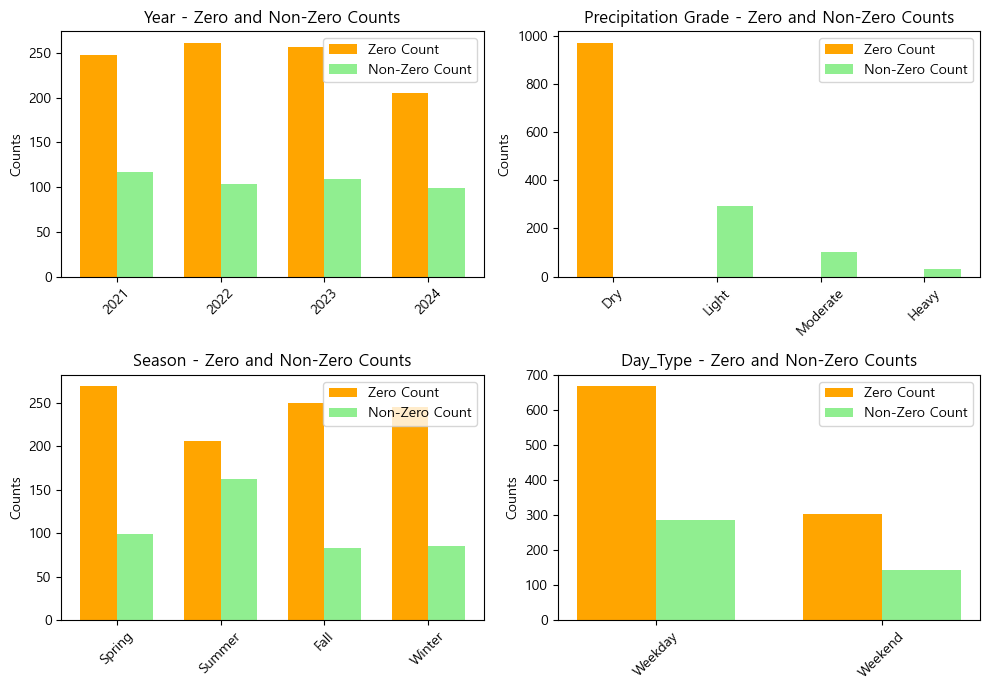

In [ ]:
# 비 온 날과 안 온날의 개수 세기

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten for easy indexing

# Define the keys and titles for each plot
keys = list(combined_stats_p1.keys())
titles = ["year", "precipitation grade", "season", "day_type"]

# Plot each dataset in a subplot
for i, key in enumerate(keys):
    value = combined_stats_p1[key]
    labels = value.index  # x-axis labels

    # Bar positions
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars for 2 bars

    # Plot side-by-side bars for Zero_Count and Non-Zero Count (cnt_nz)
    axes[i].bar(x - width/2, value["Zero_Count"], width, label='Zero Count', color='orange')
    axes[i].bar(x + width/2, value["cnt_nz"], width, label='Non-Zero Count', color='lightgreen')

    # Labeling
    axes[i].set_title(f"{titles[i]} - Zero and Non-Zero Counts")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Counts")
    axes[i].legend(loc="upper right")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [24]:
# 데이터 구조 확인
for group_name, df in combined_stats_p1.items():
    print(f"\n{group_name} 데이터프레임의 컬럼:")
    print(df.columns.tolist())


Year 데이터프레임의 컬럼:
['Total_Count', 'Zero_Count', 'cnt_nz', 'max', 'min_nz', 'mean_nz', 'median_nz', 'var_nz']

Precipitation_Grade 데이터프레임의 컬럼:
['Total_Count', 'Zero_Count', 'cnt_nz', 'max', 'min_nz', 'mean_nz', 'median_nz', 'var_nz']

Season 데이터프레임의 컬럼:
['Total_Count', 'Zero_Count', 'cnt_nz', 'max', 'min_nz', 'mean_nz', 'median_nz', 'var_nz']

Day_Type 데이터프레임의 컬럼:
['Total_Count', 'Zero_Count', 'cnt_nz', 'max', 'min_nz', 'mean_nz', 'median_nz', 'var_nz']


In [ ]:
df_year_stats = df_year_stats.reset_index()
df_pgrade_stats = df_pgrade_stats.reset_index()
df_season_stats = df_season_stats.reset_index()
df_day_stats = df_day_stats.reset_index()
df_day_stats

,Day_type,Total_Count,Zero_Count,cnt_nz,max,min_nz,mean_nz,median_nz,var_nz
0,Weekday,954,667,287,176.2,0.1,13.620906,3.4,645.612079
1,Weekend,445,303,142,76.0,0.1,13.359859,4.5,322.428377


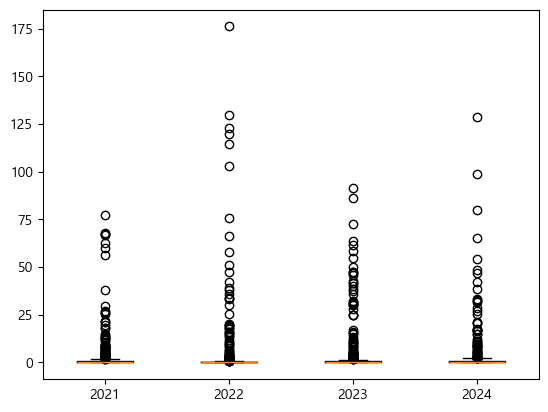

In [ ]:
year_ar = m_df.loc[:, "year"]
pgrade_ar = m_df.loc[:, "p_grade"]
season_ar = m_df.loc[:, "season"]
Day_ar = m_df.loc[:, "day_type"]

year_dict = {}
for year in year_ar.unique():
    year_dict[year] = m_df[m_df['year'] == year]["precipitation(mm)"]

fig, ax = plt.subplots()
ax.boxplot(year_dict.values())
ax.set_xticklabels(list(year_dict.keys()))

# plt.xticks(['year', 'pgrade', 'season', 'Day'], )
# plt.yticks(m_df["precipitation(mm)"])

plt.show()


적설량 (단일 그룹 분석)

In [ ]:
# 적설량
# 단일 그룹 분석 결과를 데이터 프레임으로 저장
df_year_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "year", 
                    col_name = "snow_depth(cm)")
df_Sgrade_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "s_grade", 
                    col_name = "snow_depth(cm)")
df_season_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "season", 
                    col_name = "snow_depth(cm)")
df_day_stats = group_analysis_by_single_column(
                    df = m_df, 
                    group_col_name = "day_type", 
                    col_name = "snow_depth(cm)")

# 딕셔너리로 데이터프레입 합치기
combined_stats_s1 = {
    "year": df_year_stats,
    "snow_depth_grade": df_Sgrade_stats,
    "season": df_season_stats,
    "Day Type": df_day_stats
}

print( "단일 그룹 분석 - 적설량")
# 결과 확인
for key, value in combined_stats_s1.items():
    print(f"\n\n{key} Stats (적설량):\n", value)


단일 그룹 분석 - 적설량


Year Stats (적설량):
       Total_Count  Zero_Count  cnt_nz   max  min_nz   mean_nz  median_nz  \
Year                                                                       
2021          365         340      25   5.1     0.1  2.176000        1.4   
2022          365         334      31   5.0     0.1  1.529032        1.1   
2023          365         349      16  12.2     0.2  2.806250        1.6   
2024          304         286      18  13.8     0.2  3.866667        2.7   

         var_nz  
Year             
2021   2.937733  
2022   1.727462  
2023  11.180625  
2024  11.521176  


Snow_depth_Grade Stats (적설량):
                Total_Count  Zero_Count  cnt_nz   max  min_nz    mean_nz  \
S_Grade                                                                   
No_Snow               1309        1309     NaN   NaN     NaN        NaN   
Light_Snow              54           0    54.0   2.0     0.1   0.950000   
Moderate_Snow           33           0    33.0   8.8     2.1   3.9

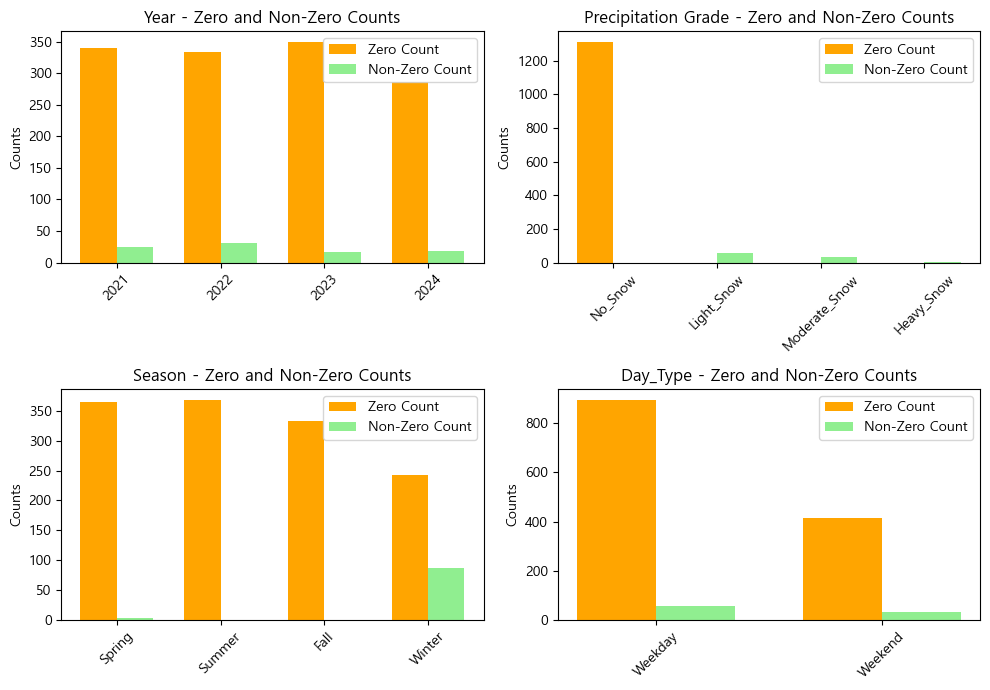

In [ ]:
# 눈 온 날과 안 온날의 개수 세기

# Set up a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()  # Flatten for easy indexing

# Define the keys and titles for each plot
keys = list(combined_stats_s1.keys())
titles = ["year", "precipitation grade", "season", "day_type"]

# Plot each dataset in a subplot
for i, key in enumerate(keys):
    value = combined_stats_s1[key]
    labels = value.index  # x-axis labels

    # Bar positions
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars for 2 bars

    # Plot side-by-side bars for Zero_Count and Non-Zero Count (cnt_nz)
    axes[i].bar(x - width/2, value["Zero_Count"], width, label='Zero Count', color='orange')
    axes[i].bar(x + width/2, value["cnt_nz"], width, label='Non-Zero Count', color='lightgreen')

    # Labeling
    axes[i].set_title(f"{titles[i]} - Zero and Non-Zero Counts")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels, rotation=45)
    axes[i].set_ylabel("Counts")
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


2. 두 개 변수 조합 분석

In [29]:
# 2-1. 연도와 등급을 조합해서 분석
# 2-2. 연도와 계절을 조합해서 분석
# 2-3. 연도와 평일/주말을 조합해서 분석
# 2-4. 등급과 계절을 조합해서 분석
# 2-5. 등급과 평일/주말을 조합해서 분석
# 2-6. 계절과 평일/주말을 조합해서 분석

- 강수량, 적설량 (두개 변수 조합 분석)

In [30]:
def group_analysis_by_two_columns(df, group_col1, group_col2, target_col):
    # 기본 통계치 계산
    stats = df.groupby([group_col1, group_col2], observed=True)[target_col].agg([
        ("tot_cnt", "count"),               # 전체 카운트
        ("cnt_nz", lambda x: (x != 0).sum()), # 0 제외 카운트
        ("zero_cnt", lambda x: (x == 0).sum()), # 0인 값의 카운트
        ("min", lambda x: x[x != 0].min()), # 0 제외 최소값
        ("max", "max"),
        ("mean", "mean"),
        ("med", "median"),
        ("var", "var"),
        ("q1", lambda x: x.quantile(0.25)),
        ("q3", lambda x: x.quantile(0.75)),
        ("iqr", lambda x: x.quantile(0.75) - x.quantile(0.25)),
        ("skew", lambda x: skew(x)),
        ("kurt", lambda x: kurtosis(x)),
        ("range", lambda x: x.max() - x.min())
    ])
    
    # 컬럼 순서 재정렬
    stats = stats[[
        # 카운트 관련 (0 포함/제외 구분)
        "tot_cnt", "cnt_nz", "zero_cnt",
        # 기본 통계치 (min은 0 제외)
        "min", "max", "mean", "med", "var",
        "q1", "q3", "iqr",
        "skew", "kurt", "range"]]
    
    return stats

- 강수량 (두 개 변수 조합 분석)

In [ ]:
# 함수 실행 예시
df_year_p_grade_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "p_grade", 
    target_col = "precipitation(mm)")
df_year_season_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "precipitation(mm)")
df_year_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")
df_p_grade_season_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "p_grade", 
    group_col2 = "season", 
    target_col = "precipitation(mm)")
df_p_grade_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "p_grade", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")
df_season_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "precipitation(mm)")

# 결과를 딕셔너리로 정리
double_group_stats_P2 = {
    "year-p_grade": df_year_p_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "p_grade-season": df_p_grade_season_stats,
    "p_grade-Day": df_p_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 강수량")
for key, value in double_group_stats_P2.items():
    print(f"\n{key} Stats (강수량):\n", value)

2. 이중 그룹 분석 - 강수량

Year-P_Grade Stats (강수량):
                tot_cnt  cnt_nz  zero_cnt   min    max        mean     med  \
Year P_Grade                                                                
2021 Dry           248       0       248   NaN    0.0    0.000000    0.00   
     Light          88      88         0   0.1    9.3    2.860227    1.70   
     Moderate       21      21         0  10.5   38.2   19.452381   18.10   
     Heavy           8       8         0  56.2   77.4   65.787500   67.15   
2022 Dry           261       0       261   NaN    0.0    0.000000    0.00   
     Light          68      68         0   0.1    9.9    2.107353    1.25   
     Moderate       26      26         0  10.4   47.2   23.634615   19.30   
     Heavy          10      10         0  51.1  176.2  101.750000  108.75   
2023 Dry           256       0       256   NaN    0.0    0.000000    0.00   
     Light          70      70         0   0.1    9.7    2.467143    1.50   
     Moderate       31      31

In [32]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1399 non-null   float64       
 2   Precipitation(mm)  1399 non-null   float64       
 3   Snow_depth(cm)     1399 non-null   float64       
 4   Day_type           1399 non-null   object        
 5   Season             1399 non-null   category      
 6   Year               1399 non-null   int32         
 7   FD_Grade           1399 non-null   category      
 8   P_Grade            1399 non-null   category      
 9   S_Grade            1399 non-null   category      
dtypes: category(4), datetime64[ns](1), float64(3), int32(1), object(1)
memory usage: 66.5+ KB


- 적설량 (두 개 변수 조합 분석)

In [33]:
# 함수 실행 예시
df_year_s_grade_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "s_grade", 
    target_col = "snow_depth(cm)")
df_year_season_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "season", 
    target_col = "snow_depth(cm)")
df_year_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "year", 
    group_col2 = "day_type", 
    target_col = "snow_depth(cm)")
df_s_grade_season_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "s_grade", 
    group_col2 = "season", 
    target_col = "snow_depth(cm)")
df_s_grade_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "s_grade", 
    group_col2 = "day_type", 
    target_col = "snow_depth(cm)")
df_season_day_stats = group_analysis_by_two_columns(
    df = m_df,
    group_col1 = "season", 
    group_col2 = "day_type", 
    target_col = "snow_depth(cm)")

# 결과를 딕셔너리로 정리
double_group_stats_S2 = {
    "year-s_grade": df_year_s_grade_stats,
    "year-season": df_year_season_stats,
    "year-Day": df_year_day_stats,
    "s_grade-season": df_s_grade_season_stats,
    "s_grade-Day": df_s_grade_day_stats,
    "season-Day": df_season_day_stats
}

# 결과 출력
print("2. 이중 그룹 분석 - 적설량")
for key, value in double_group_stats_S2.items():
    print(f"\n{key} Stats (적설량):\n", value)

2. 이중 그룹 분석 - 적설량

Year-S_Grade Stats (적설량):
                     tot_cnt  cnt_nz  zero_cnt   min   max       mean    med  \
Year S_Grade                                                                  
2021 No_Snow            340       0       340   NaN   0.0   0.000000   0.00   
     Light_Snow          14      14         0   0.1   1.8   0.821429   0.85   
     Moderate_Snow       11      11         0   2.3   5.1   3.900000   4.20   
2022 No_Snow            334       0       334   NaN   0.0   0.000000   0.00   
     Light_Snow          25      25         0   0.1   1.9   0.976000   0.90   
     Moderate_Snow        6       6         0   2.4   5.0   3.833333   3.80   
2023 No_Snow            349       0       349   NaN   0.0   0.000000   0.00   
     Light_Snow           9       9         0   0.2   1.7   0.788889   0.60   
     Moderate_Snow        6       6         0   2.1   8.8   4.266667   3.60   
     Heavy_Snow           1       1         0  12.2  12.2  12.200000  12.20   
2024 N

C:\Users\human\AppData\Local\Temp\ipykernel_5364\3779905641.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ("skew", lambda x: skew(x)),
C:\Users\human\AppData\Local\Temp\ipykernel_5364\3779905641.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ("kurt", lambda x: kurtosis(x)),


3. 세 개 변수 조합 분석

In [34]:
# 3-1. 연도와 등급과 계절을 조합해서 분석
# 3-2. 연도와 등급과 평일/주말을 조합해서 분석
# 3-3. 등급과 계절과 평일/주말을 주합해서 분석

- 강수량, 적설량 (세개 변수 조합 분석)

In [35]:
def group_analysis_by_three_columns(df, group_col1, group_col2, group_col3, target_col):
    # 기본 통계치 계산
    stats = df.groupby([group_col1, group_col2, group_col3], observed=True)[target_col].agg([
        ("tot_cnt", "count"),               # 전체 카운트
        ("cnt_nz", lambda x: (x != 0).sum()), # 0 제외 카운트
        ("zero_cnt", lambda x: (x == 0).sum()), # 0인 값의 카운트
        ("min", lambda x: x[x != 0].min()), # 0 제외 최소값
        ("max", "max"),
        ("mean", "mean"),
        ("med", "median"),
        ("var", "var"),
        ("q1", lambda x: x.quantile(0.25)),
        ("q3", lambda x: x.quantile(0.75)),
        ("iqr", lambda x: x.quantile(0.75) - x.quantile(0.25)),
        ("skew", lambda x: skew(x)),
        ("kurt", lambda x: kurtosis(x)),
        ("range", lambda x: x.max() - x.min())
    ])
    
    # 컬럼 순서 재정렬
    stats = stats[[
        # 카운트 관련 (0 포함/제외 구분)
        "tot_cnt", "cnt_nz", "zero_cnt",
        # 기본 통계치 (min은 0 제외)
        "min", "max", "mean", "med", "var",
        "q1", "q3", "iqr",
        "skew", "kurt", "range"]]
    
    return stats

- 강수량 (세개 변수 조합 분석)

In [ ]:
# 함수 실행 예시
df_year_p_grade_season_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "p_grade", 
                                group_col3 = "season", 
                                target_col = "precipitation(mm)")
df_year_p_grade_day_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "p_grade", 
                                group_col3 = "day_type", 
                                target_col = "precipitation(mm)")
df_p_grade_season_day_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "p_grade", 
                                group_col2 = "season", 
                                group_col3 = "day_type", 
                                target_col = "precipitation(mm)")

# 결과를 딕셔너리로 정리
triple_group_stats_P3 = {
    "year-p_grade-season": df_year_p_grade_season_stats,
    "year-p_grade-Day": df_year_p_grade_day_stats,
    "p_grade-season-Day": df_p_grade_season_day_stats,
}

# 결과 출력
print("2. 삼중 그룹 분석 - 강수량")
for key, value in triple_group_stats_P3.items():
    print(f"\n{key} Stats: (강수량)\n", value)

2. 삼중 그룹 분석 - 강수량

Year-P_Grade-Season Stats: (강수량)
                       tot_cnt  cnt_nz  zero_cnt   min    max        mean  \
Year P_Grade  Season                                                       
2021 Dry      Spring       57       0        57   NaN    0.0    0.000000   
              Summer       58       0        58   NaN    0.0    0.000000   
              Fall         66       0        66   NaN    0.0    0.000000   
              Winter       67       0        67   NaN    0.0    0.000000   
     Light    Spring       25      25         0   0.1    9.2    3.548000   
              Summer       23      23         0   0.1    9.3    3.560870   
              Fall         17      17         0   0.3    6.4    2.776471   
              Winter       23      23         0   0.1    9.2    1.473913   
     Moderate Spring        7       7         0  12.3   26.3   19.828571   
              Summer        7       7         0  10.5   38.2   19.228571   
              Fall          7      

- 적설량 (세개 변수 조합 분석)

In [37]:
# 함수 실행 예시
df_year_s_grade_season_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "s_grade", 
                                group_col3 = "season", 
                                target_col = "snow_depth(cm)")
df_year_s_grade_day_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "s_grade", 
                                group_col3 = "day_type", 
                                target_col = "snow_depth(cm)")
df_s_grade_season_day_stats = group_analysis_by_three_columns(
                                df = m_df,
                                group_col1 = "s_grade", 
                                group_col2 = "season", 
                                group_col3 = "day_type", 
                                target_col = "snow_depth(cm)")

# 결과를 딕셔너리로 정리
triple_group_stats_S3 = {
    "year-s_grade-season": df_year_s_grade_season_stats,
    "year-s_grade-Day": df_year_s_grade_day_stats,
    "s_grade-season-Day": df_s_grade_season_day_stats,
}

# 결과 출력
print("2. 삼중 그룹 분석 - 적설량")
for key, value in triple_group_stats_S3.items():
    print(f"\n{key} Stats: (적설량)\n", value)

2. 삼중 그룹 분석 - 적설량

Year-S_Grade-Season Stats: (적설량)
                            tot_cnt  cnt_nz  zero_cnt   min   max       mean  \
Year S_Grade       Season                                                     
2021 No_Snow       Spring       90       0        90   NaN   0.0   0.000000   
                   Summer       92       0        92   NaN   0.0   0.000000   
                   Fall         91       0        91   NaN   0.0   0.000000   
                   Winter       67       0        67   NaN   0.0   0.000000   
     Light_Snow    Winter       14      14         0   0.1   1.8   0.821429   
     Moderate_Snow Spring        2       2         0   2.3   2.3   2.300000   
                   Winter        9       9         0   3.3   5.1   4.255556   
2022 No_Snow       Spring       91       0        91   NaN   0.0   0.000000   
                   Summer       92       0        92   NaN   0.0   0.000000   
                   Fall         91       0        91   NaN   0.0   0.000000   

C:\Users\human\AppData\Local\Temp\ipykernel_5364\1731610920.py:15: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ("skew", lambda x: skew(x)),
C:\Users\human\AppData\Local\Temp\ipykernel_5364\1731610920.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ("kurt", lambda x: kurtosis(x)),


4. 모든 변수 조합 분석

In [38]:
# 4-1. 연도와 등급과 계절과 평일/주말을 조합해서 분석

- 강수량, 적설량 (네개 변수 조합 분석)

In [39]:
def group_analysis_by_four_columns(df, group_col1, group_col2, group_col3, group_col4, target_col):
    # 기본 통계치 계산
    stats = df.groupby([group_col1, group_col2, group_col3, group_col4], observed=True)[target_col].agg([
        ("tot_cnt", "count"),               # 전체 카운트
        ("cnt_nz", lambda x: (x != 0).sum()), # 0 제외 카운트
        ("zero_cnt", lambda x: (x == 0).sum()), # 0인 값의 카운트
        ("min", lambda x: x[x != 0].min()), # 0 제외 최소값
        ("max", "max"),
        ("mean", "mean"),
        ("med", "median"),
        ("var", "var"),
        ("q1", lambda x: x.quantile(0.25)),
        ("q3", lambda x: x.quantile(0.75)),
        ("iqr", lambda x: x.quantile(0.75) - x.quantile(0.25)),
        ("skew", lambda x: skew(x)),
        ("kurt", lambda x: kurtosis(x)),
        ("range", lambda x: x.max() - x.min())
    ])
    
    # 컬럼 순서 재정렬
    stats = stats[[
        # 카운트 관련 (0 포함/제외 구분)
        "tot_cnt", "cnt_nz", "zero_cnt",
        # 기본 통계치 (min은 0 제외)
        "min", "max", "mean", "med", "var",
        "q1", "q3", "iqr",
        "skew", "kurt", "range"]]
    
    return stats

- 강수량 (네개 변수 조합 분석)

In [ ]:
# 함수 실행 예시
df_year_season_p_grade_day_stats = group_analysis_by_four_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "season",
                                group_col3 = "p_grade",  
                                group_col4 = "day_type",
                                target_col = "precipitation(mm)")

# 결과를 딕셔너리로 정리
quadruple_group_stats_P4 = {
    "year-p_grade-season": df_year_season_p_grade_day_stats
}

# 결과 출력
print("2. 사중 그룹 분석 - 강수량")
for key, value in quadruple_group_stats_P4.items():
    print(f"\n{key} Stats: (강수량) \n", value)

2. 사중 그룹 분석 - 강수량

Year-P_Grade-Season Stats: (강수량) 
                                tot_cnt  cnt_nz  zero_cnt   min   max  \
Year Season P_Grade  Day_type                                          
2021 Spring Dry      Weekday        43       0        43   NaN   0.0   
                     Weekend        14       0        14   NaN   0.0   
            Light    Weekday        16      16         0   0.1   8.9   
                     Weekend         9       9         0   0.1   9.2   
            Moderate Weekday         4       4         0  12.3  26.3   
...                                ...     ...       ...   ...   ...   
2024 Winter Dry      Weekend        12       0        12   NaN   0.0   
            Light    Weekday        11      11         0   0.2   9.7   
                     Weekend         6       6         0   0.4   3.1   
            Moderate Weekday         2       2         0  10.9  17.8   
                     Weekend         1       1         0  17.1  17.1   

         

- 적설량 (네개 변수 조합 분석)

In [ ]:
# 함수 실행 예시
df_year_season_s_grade_day_stats = group_analysis_by_four_columns(
                                df = m_df,
                                group_col1 = "year", 
                                group_col2 = "season",
                                group_col3 = "s_grade",  
                                group_col4 = "day_type",
                                target_col = "snow_depth(cm)")

# 결과를 딕셔너리로 정리
quadruple_group_stats_S4 = {
    "year-s_grade-season": df_year_season_s_grade_day_stats
}

# 결과 출력
print("2. 사중 그룹 분석 - 적설량")
for key, value in quadruple_group_stats_S4.items():
    print(f"\n{key} Stats: (적설량) \n", value)

2. 사중 그룹 분석 - 적설량

Year-S_Grade-Season Stats: (적설량) 
                                     tot_cnt  cnt_nz  zero_cnt   min   max  \
Year Season S_Grade       Day_type                                          
2021 Spring No_Snow       Weekday        62       0        62   NaN   0.0   
                          Weekend        28       0        28   NaN   0.0   
            Moderate_Snow Weekday         1       1         0   2.3   2.3   
                          Weekend         1       1         0   2.3   2.3   
     Summer No_Snow       Weekday        66       0        66   NaN   0.0   
                          Weekend        26       0        26   NaN   0.0   
     Fall   No_Snow       Weekday        61       0        61   NaN   0.0   
                          Weekend        30       0        30   NaN   0.0   
     Winter No_Snow       Weekday        44       0        44   NaN   0.0   
                          Weekend        23       0        23   NaN   0.0   
            Light_Snow

- 시각화

In [ ]:
m_df['snow_depth(mm)'] = m_df['snow_depth(cm)'] * 10

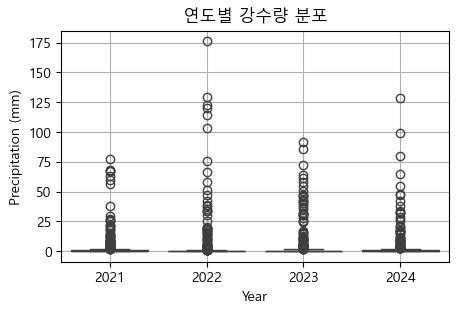

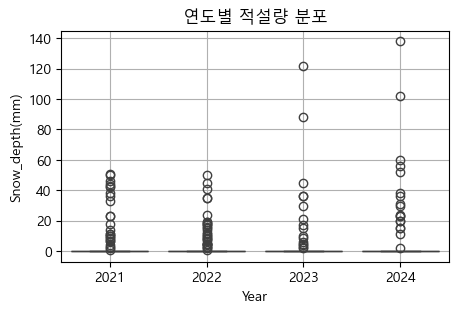

In [43]:
plt.figure(figsize=(5, 3))
sns.boxplot(x='year', y='precipitation(mm)', data=m_df)
plt.title('연도별 강수량 분포')
plt.xlabel('year')
plt.ylabel('precipitation (mm)')
plt.grid(True)

plt.figure(figsize=(5, 3))
sns.boxplot(x='year', y='snow_depth(mm)', data=m_df)
plt.title('연도별 적설량 분포')
plt.xlabel('year')
plt.ylabel('snow_depth(mm)')
plt.grid(True)

plt.show()


C:\Users\human\AppData\Local\Temp\ipykernel_5364\1457363510.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_fine_dust = m_df.groupby('Season')['Fine_dust(㎍/㎥)'].mean()
C:\Users\human\AppData\Local\Temp\ipykernel_5364\1457363510.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_precipitation = m_df.groupby('Season')['Precipitation(mm)'].mean()
C:\Users\human\AppData\Local\Temp\ipykernel_5364\1457363510.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tr

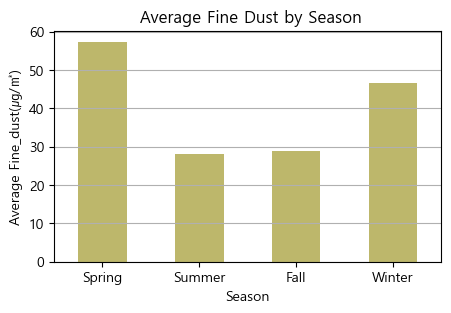

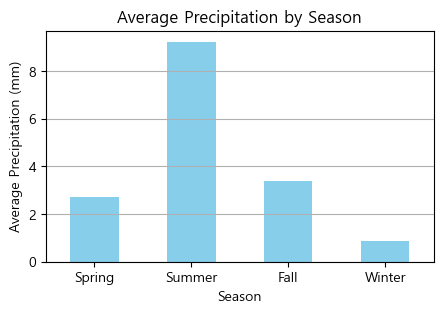

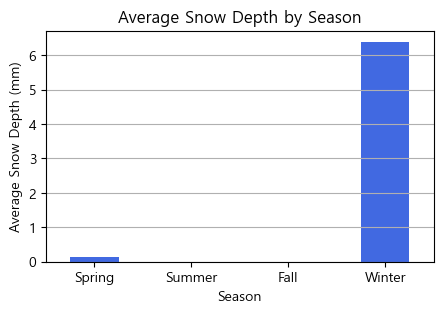

In [44]:
# 계절별 평균 미세먼지농도 계산
seasonal_fine_dust = m_df.groupby('season')['Fine_dust(㎍/㎥)'].mean()
# 막대 그래프 그리기
plt.figure(figsize=(5,3))
seasonal_fine_dust.plot(kind='bar', color='DarkKhaki')
plt.title(' Average Fine Dust by season')
plt.xlabel('season')
plt.ylabel('Average Fine_dust(㎍/㎥)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# 계절별 평균 강수량 계산
seasonal_precipitation = m_df.groupby('season')['precipitation(mm)'].mean()
# 막대 그래프 그리기
plt.figure(figsize=(5,3))
seasonal_precipitation.plot(kind='bar', color='skyblue')
plt.title('Average precipitation by season')
plt.xlabel('season')
plt.ylabel('Average precipitation (mm)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# 계절별 평균 적설량 계산
seasonal_snow_depth = m_df.groupby('season')['snow_depth(mm)'].mean()
# 막대 그래프 그리기
plt.figure(figsize=(5,3))
seasonal_snow_depth.plot(kind='bar', color='RoyalBlue')
plt.title('Average Snow Depth by season')
plt.xlabel('season')
plt.ylabel('Average Snow Depth (mm)')
plt.xticks(rotation=0)
plt.grid(axis='y')


plt.show()

C:\Users\human\AppData\Local\Temp\ipykernel_5364\498459889.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_season_grade_avg = m_df.groupby(['Year', 'Season', 'P_Grade'])['Precipitation(mm)'].mean().unstack(level=1).unstack(level=1)


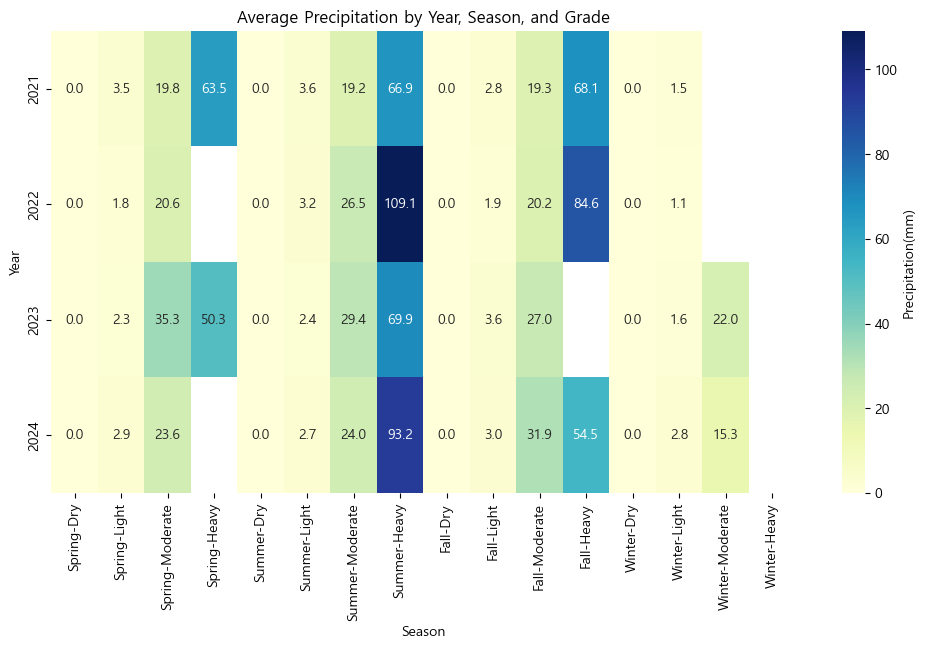

In [45]:
# 연도, 계절, 등급별 평균 강수량 계산
year_season_grade_avg = m_df.groupby(['year', 'season', 'p_grade'])['precipitation(mm)'].mean().unstack(level=1).unstack(level=1)

# 히트맵 그리기
plt.figure(figsize=(12, 6))
sns.heatmap(year_season_grade_avg, annot=True, cmap='YlGnBu', fmt=".1f", cbar_kws={'label': 'precipitation(mm)'})
plt.title('Average precipitation by year, season, and grade')
plt.xlabel('season')
plt.ylabel('year')

plt.show()

C:\Users\human\AppData\Local\Temp\ipykernel_5364\3535831800.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_season_grade_avg = m_df.groupby(['Year', 'Season', 'P_Grade'])['Snow_depth(mm)'].mean().unstack(level=1).unstack(level=1)


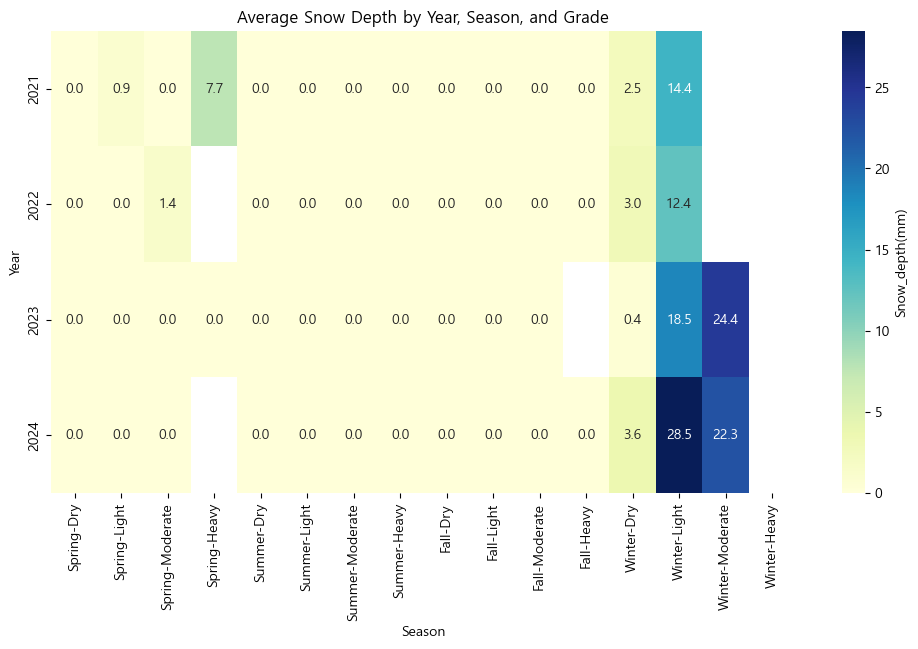

In [46]:
# 연도, 계절, 등급별 평균 적설량 계산
year_season_grade_avg = m_df.groupby(['year', 'season', 'p_grade'])['snow_depth(mm)'].mean().unstack(level=1).unstack(level=1)

# 히트맵 그리기
plt.figure(figsize=(12, 6))
sns.heatmap(year_season_grade_avg, annot=True, cmap='YlGnBu', fmt=".1f", cbar_kws={'label': 'snow_depth(mm)'})
plt.title('Average Snow Depth by year, season, and grade')
plt.xlabel('season')
plt.ylabel('year')

plt.show()

In [47]:
m_df

,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year,FD_Grade,P_Grade,S_Grade,Snow_depth(mm)
0,2021-01-01,36.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
1,2021-01-02,43.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
2,2021-01-03,47.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
3,2021-01-04,50.000000,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
4,2021-01-05,37.000000,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1394,2024-10-26,26.000000,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1395,2024-10-27,27.000000,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1396,2024-10-28,38.000000,0.0,0.0,Weekday,Fall,2024,Normal,Dry,No_Snow,0.0
1397,2024-10-29,28.840909,0.0,0.0,Weekday,Fall,2024,Good,Dry,No_Snow,0.0


- 미세먼지, 강수량, 적설량 시각화

In [ ]:
# deep copy를 사용하여 새로운 데이터프레임 생성
m_df2 = m_df.copy()

from sklearn.preprocessing import MinMaxScaler

# 스케일링할 컬럼 선택
cols_to_scale = ['Fine_dust(㎍/㎥)', 'precipitation(mm)', 'snow_depth(mm)']

# MinMaxScaler 생성 및 fit_transform
scaler = MinMaxScaler()
m_df2[cols_to_scale] = scaler.fit_transform(m_df[cols_to_scale])

# 결과 확인
print(m_df2[cols_to_scale].head())

   Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(mm)
0        0.073491                0.0             0.0
1        0.091864                0.0             0.0
2        0.102362                0.0             0.0
3        0.110236                0.0             0.0
4        0.076115                0.0             0.0


In [49]:
m_df

,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year,FD_Grade,P_Grade,S_Grade,Snow_depth(mm)
0,2021-01-01,36.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
1,2021-01-02,43.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
2,2021-01-03,47.000000,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
3,2021-01-04,50.000000,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
4,2021-01-05,37.000000,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1394,2024-10-26,26.000000,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1395,2024-10-27,27.000000,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1396,2024-10-28,38.000000,0.0,0.0,Weekday,Fall,2024,Normal,Dry,No_Snow,0.0
1397,2024-10-29,28.840909,0.0,0.0,Weekday,Fall,2024,Good,Dry,No_Snow,0.0


In [50]:
m_df2

,Date,Fine_dust(㎍/㎥),Precipitation(mm),Snow_depth(cm),Day_type,Season,Year,FD_Grade,P_Grade,S_Grade,Snow_depth(mm)
0,2021-01-01,0.073491,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
1,2021-01-02,0.091864,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
2,2021-01-03,0.102362,0.0,0.0,Weekend,Winter,2021,Normal,Dry,No_Snow,0.0
3,2021-01-04,0.110236,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
4,2021-01-05,0.076115,0.0,0.0,Weekday,Winter,2021,Normal,Dry,No_Snow,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1394,2024-10-26,0.047244,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1395,2024-10-27,0.049869,0.0,0.0,Weekend,Fall,2024,Good,Dry,No_Snow,0.0
1396,2024-10-28,0.078740,0.0,0.0,Weekday,Fall,2024,Normal,Dry,No_Snow,0.0
1397,2024-10-29,0.054701,0.0,0.0,Weekday,Fall,2024,Good,Dry,No_Snow,0.0


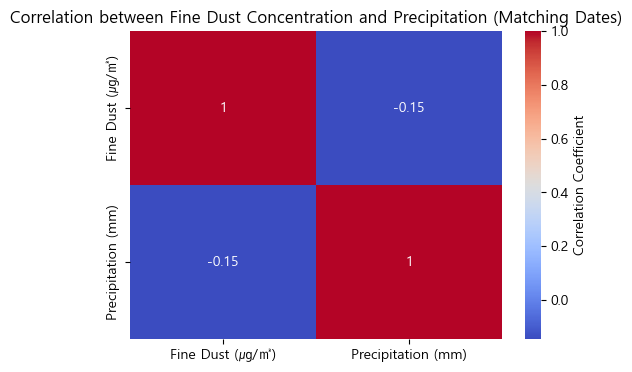

In [ ]:
# 미세먼지와 강수량의 관계

# 강수량이 0이 아닌 날의 인덱스 찾기
non_zero_precipitation_dates = m_df2[m_df2['precipitation(mm)'] > 0]['Date']

# 같은 날의 미세먼지 농도 추출
filtered_df = m_df2[m_df2['Date'].isin(non_zero_precipitation_dates)]

# 상관관계 계산
corr_matrix = filtered_df[['Fine_dust(㎍/㎥)', 'precipitation(mm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation between Fine Dust Concentration and precipitation (Matching Dates)')
plt.xticks([0.5, 1.5], ['Fine Dust (㎍/㎥)', 'precipitation (mm)'])
plt.yticks([0.5, 1.5], ['Fine Dust (㎍/㎥)', 'precipitation (mm)'])
plt.show()


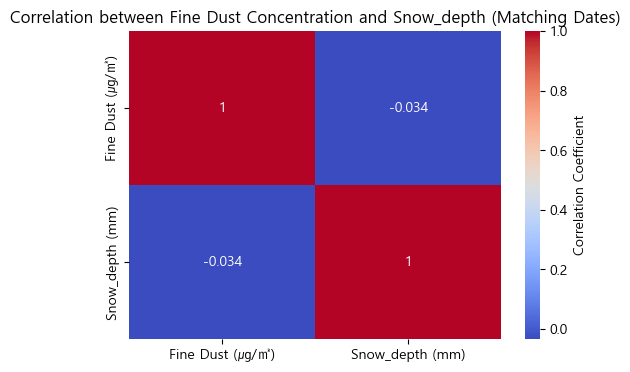

In [ ]:
# 미세먼지와 적설량의 관계

# 강수량이 0이 아닌 날의 인덱스 찾기
non_zero_snow_depth_dates = m_df2[m_df2['snow_depth(cm)'] > 0]['Date']

# 같은 날의 미세먼지 농도 추출
filtered_df = m_df[m_df2['Date'].isin(non_zero_snow_depth_dates)]

# 상관관계 계산
corr_matrix = filtered_df[['Fine_dust(㎍/㎥)', 'snow_depth(cm)']].corr()

# 히트맵 그리기
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation between Fine Dust Concentration and snow_depth (Matching Dates)')
plt.xticks([0.5, 1.5], ['Fine Dust (㎍/㎥)', 'snow_depth (mm)'])
plt.yticks([0.5, 1.5], ['Fine Dust (㎍/㎥)', 'snow_depth (mm)'])
plt.show()

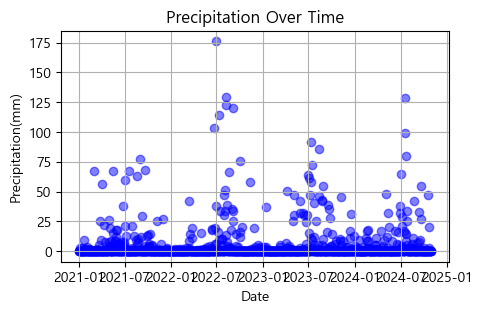

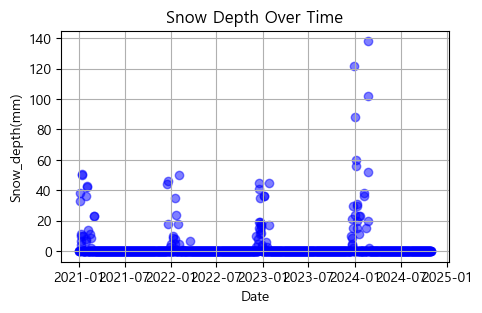

In [ ]:
# 시간에 따른 강수량과 적설량

plt.figure(figsize=(5, 3))
plt.scatter(m_df['Date'], m_df['precipitation(mm)'], alpha=0.5, color='blue')
plt.title('precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('precipitation(mm)')
plt.grid(True)

plt.figure(figsize=(5, 3))
plt.scatter(m_df['Date'], m_df['snow_depth(mm)'], alpha=0.5, color='blue')
plt.title('Snow Depth Over Time')
plt.xlabel('Date')
plt.ylabel('snow_depth(mm)')
plt.grid(True)


plt.show()

In [54]:
m_df.to_csv('data/m_df.csv')
m_df2.to_csv('data/m_df2.csv')

In [55]:
m_df.info(), m_df2.info()
m_df.head(), m_df2.head()
# m_df2는 m_df가 스케일된 것

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1399 non-null   float64       
 2   Precipitation(mm)  1399 non-null   float64       
 3   Snow_depth(cm)     1399 non-null   float64       
 4   Day_type           1399 non-null   object        
 5   Season             1399 non-null   category      
 6   Year               1399 non-null   int32         
 7   FD_Grade           1399 non-null   category      
 8   P_Grade            1399 non-null   category      
 9   S_Grade            1399 non-null   category      
 10  Snow_depth(mm)     1399 non-null   float64       
dtypes: category(4), datetime64[ns](1), float64(4), int32(1), object(1)
memory usage: 77.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data colu

(        Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
 0 2021-01-01            36.0                0.0             0.0  Weekend   
 1 2021-01-02            43.0                0.0             0.0  Weekend   
 2 2021-01-03            47.0                0.0             0.0  Weekend   
 3 2021-01-04            50.0                0.0             0.0  Weekday   
 4 2021-01-05            37.0                0.0             0.0  Weekday   
 
    Season  Year FD_Grade P_Grade  S_Grade  Snow_depth(mm)  
 0  Winter  2021   Normal     Dry  No_Snow             0.0  
 1  Winter  2021   Normal     Dry  No_Snow             0.0  
 2  Winter  2021   Normal     Dry  No_Snow             0.0  
 3  Winter  2021   Normal     Dry  No_Snow             0.0  
 4  Winter  2021   Normal     Dry  No_Snow             0.0  ,
         Date  Fine_dust(㎍/㎥)  Precipitation(mm)  Snow_depth(cm) Day_type  \
 0 2021-01-01        0.073491                0.0             0.0  Weekend   
 1 2021-01-02  

In [56]:
temp_df = pd.read_csv('data/temperature.csv')
temp_df.info(), temp_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1399 non-null   int64  
 1   date        1399 non-null   object 
 2   avg_temp    1399 non-null   float64
 3   min_temp    1399 non-null   float64
 4   max_temp    1399 non-null   float64
 5   day_type    1399 non-null   object 
 6   season      1399 non-null   object 
 7   year        1399 non-null   int64  
 8   at_grade    1399 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 98.5+ KB


(None,
 Index(['Unnamed: 0', 'date', 'avg_temp', 'min_temp', 'max_temp', 'day_type',
        'season', 'year', 'at_grade'],
       dtype='object'))

In [ ]:
temp_df = temp_df[['date', 'avg_temp', 'min_temp', 'max_temp', 'at_grade']]
temp_df['date'] = pd.to_datetime(temp_df['date'])
m_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1399 non-null   float64       
 2   Precipitation(mm)  1399 non-null   float64       
 3   Snow_depth(cm)     1399 non-null   float64       
 4   Day_type           1399 non-null   object        
 5   Season             1399 non-null   category      
 6   Year               1399 non-null   int32         
 7   FD_Grade           1399 non-null   category      
 8   P_Grade            1399 non-null   category      
 9   S_Grade            1399 non-null   category      
 10  Snow_depth(mm)     1399 non-null   float64       
dtypes: category(4), datetime64[ns](1), float64(4), int32(1), object(1)
memory usage: 77.4+ KB


In [58]:
m_df = m_df.iloc[:, 0:10]
temp_df.info(), m_df.info(), 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1399 non-null   datetime64[ns]
 1   avg_temp  1399 non-null   float64       
 2   min_temp  1399 non-null   float64       
 3   max_temp  1399 non-null   float64       
 4   at_grade  1399 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1399 non-null   datetime64[ns]
 1   Fine_dust(㎍/㎥)     1399 non-null   float64       
 2   Precipitation(mm)  1399 non-null   float64       
 3   Snow_depth(cm)     1399 non-null   float64       
 4   Day_type           1399 non-null   object        
 5   Sea

(None, None)

In [60]:
all_df = pd.merge(m_df, temp_df, how='outer', on='date')
all_df

KeyError: 'date'

In [ ]:
# 평균기온과 강수량의 관계

plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temp', y='precipitation', data=all_df, hue='season', palette='Set1')
plt.title('Average Temperature vs precipitation by season')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('precipitation (mm)')
plt.legend(title='season')
plt.show()


NameError: name 'all_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
all_df.info()
all_df.loc[150:250]

In [ ]:
# 최저 기온과 적설량의 관계

plt.figure(figsize=(10, 6))
sns.scatterplot(x='min_temp', y='snow_depth', data=all_df, hue='season', palette='Set2')
plt.title('Minimum Temperature vs Snow Depth by season')
plt.xlabel('Minimum Temperature (°C)')
plt.ylabel('Snow Depth (cm)')
plt.legend(title='season')
plt.show()


In [ ]:
# 최고 기온과 미세먼지의 관계

plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temp', y='fine_dust', data=all_df, hue='season', palette='Set3')
plt.title('Average Temperature vs Fine Dust by season')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Fine Dust')
plt.legend(title='season')
plt.show()
